# Init

In [1]:
%matplotlib inline

import os
import arrow
import pickle
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt

import cfg4py
import omicron
import numpy as np
from omicron.core.types import FrameType
from omicron.core.timeframe import tf
from omicron.models.securities import Securities
from omicron.models.security import Security

from alpha.core.features import predict_by_moving_average, moving_average,fillna
from alpha.plotting import draw_trendline
from alpha.plotting.candlestick import Candlestick
from alpha.config import get_config_dir
from alpha.core.morph import MorphFeatures

cfg4py.init(get_config_dir())
await omicron.init()

    
clear_output()

In [2]:
async def get_bars(code:str, n:int, end:str=None, frame_type:str="1d"):
    if code.startswith("6"):
        code += ".XSHG"
    else:
        code += ".XSHE"
    sec = Security(code)
    frame_type = FrameType(frame_type)
    end = arrow.now() if end is None else arrow.get(end)
    end = tf.floor(end, frame_type)
    
    start = tf.shift(end, -n + 1, frame_type)
    return await sec.load_bars(start, end, frame_type)

# 加载数据

In [ ]:
with open("/data/stocks/ds_even_30m_300_5000.pkl", "rb") as f:
    ds = pickle.load(f)

In [ ]:
df = pd.DataFrame(ds["data"], columns=["code", "y", "bars"])

In [ ]:
def ylabel(bars):
    ybars= bars[-5:]
    yclose = ybars["close"][-5:]
    c0 = bars["close"][-6]
    
    max_adv = max(yclose) / c0 - 1
    max_dec = abs(min(yclose) / c0 - 1)
    
    agg = max if max_adv > max_dec else min
    
    return agg(yclose) / c0 - 1
    
df.y = df.bars.apply(lambda x: ylabel(x))

In [ ]:
df[df.y>0.1]

In [ ]:
def draw(i):
    code, y, bars = df.loc[i]
    xend = bars["frame"][-6]
    desc = f"{code.split('.')[0]} {str(xend).replace('+08:00', '')} {y:.0%}"
    draw_trendline(bars["close"], 5, save_to = f"/data/twins/{code}.jpg", desc=desc)
    
for i in df[df.y>0.1].index:
    draw(i)

In [ ]:
code, y, bars = df.loc[625]
close = bars["close"]
print(code, close[-6:])
predict_by_moving_average(close[:-5], 10, 5)

# build morph库

In [ ]:
m = MorphFeatures(FrameType.DAY)

def add_pattern(bars):
    for i in range(220):
        close = bars["close"][i:i+81]
        if np.count_nonzero(np.isfinite(close)) < 81*0.9:
            continue
            
        close = fillna(close.copy())
        m.encode(close)

df.bars.apply(add_pattern)
m.dump()

# 增加样本

In [3]:
zgc_30 = await get_bars("000931", 120, "2021-08-30 11:00", "30m")

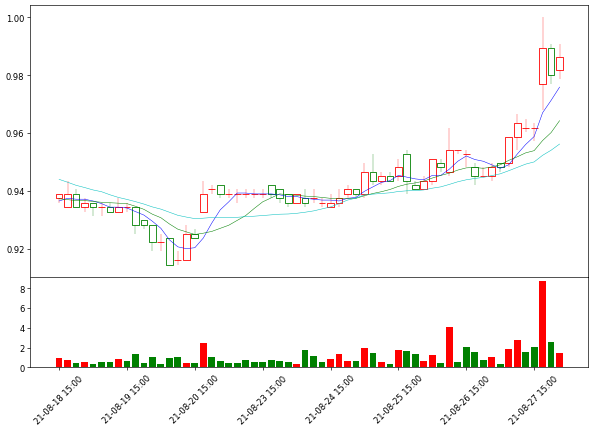

In [5]:
cs = Candlestick(row=2, fig_size=(12,8))
cs.plot(zgc_30, [5, 10, 20])

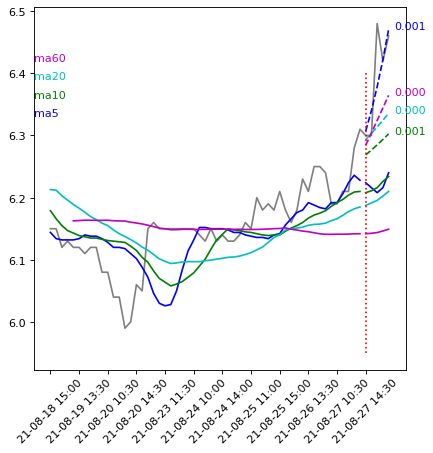

In [6]:
draw_trendline(zgc_30, 5)

In [7]:
np.argsort([1,2,3])

array([0, 1, 2])